<a href="https://colab.research.google.com/github/risper25/clinical-llm-finetuning-lora/blob/main/clinicallm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#login to hugging face
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

In [ ]:
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.41.0 trl==0.4.7

In [ ]:
!pip install --upgrade accelerate peft bitsandbytes transformers trl



  Using cached accelerate-1.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached peft-0.15.2-py3-none-any.whl.metadata (13 kB)
  Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl.metadata (5.0 kB)
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached trl-0.16.1-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
Using cached accelerate-1.6.0-py3-none-any.whl (354 kB)
Using cached peft-0.15.2-py3-none-any.whl (411 kB)
Using cached bitsandbytes-0.45.5-py3-none-manylinux_2_24_x86_64.whl (76.1 MB)
Using cached transformers-4.51.3-py3-none-any.whl (10.4 MB)
Using cached trl-0.16.1-py3-none-any.whl (336 kB)
Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tok

In [ ]:
!pip install tokenizers datasets


# **Text preprocessing**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
#load dataset
df=pd.read_csv("/content/train.csv")
df.head()
print(len(df))

400


In [ ]:
print("\n🔍 Null values per column:")
print(df.isnull().sum())


🔍 Null values per column:
Master_Index             0
County                   0
Health level             0
Years of Experience    100
Prompt                   0
Nursing Competency       0
Clinical Panel           0
Clinician                0
GPT4.0                   0
LLAMA                    0
GEMINI                   0
DDX SNOMED               1
dtype: int64


In [ ]:
df = df.dropna(subset=['DDX SNOMED'])

In [ ]:
print("\n📊 Unique values per column:")
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"\n🔹 Column: {col}")
    print(f"   Unique Count: {unique_vals}")

    # Print actual unique values, limiting to first 20 if too many
    unique_items = df[col].unique()
    if len(unique_items) > 20:
        print(f"   Sample Values (20 of {len(unique_items)}): {unique_items[:20]}")
    else:
        print(f"   Values: {unique_items}")



📊 Unique values per column:

🔹 Column: Master_Index
   Unique Count: 399
   Sample Values (20 of 399): ['ID_VBWWP' 'ID_XMBBY' 'ID_JZNZW' 'ID_QOQTK' 'ID_ZFJBM' 'ID_SFQGM'
 'ID_ABUJJ' 'ID_SUOCB' 'ID_MIAYN' 'ID_OHZDT' 'ID_LPHGS' 'ID_QRQMM'
 'ID_KOFOB' 'ID_IAYWV' 'ID_RJQBZ' 'ID_CXPAN' 'ID_DBLHH' 'ID_AXWOO'
 'ID_GULKY' 'ID_IDJRT']

🔹 Column: County
   Unique Count: 5
   Values: ['uasin gishu' 'kiambu' 'kakamega' 'elgeiyo marakwet' 'bungoma']

🔹 Column: Health level
   Unique Count: 7
   Values: ['sub county hospitals and nursing homes' 'national referral hospitals'
 'health centres' 'dispensaries and private clinics' 'county hospitals'
 'community health centers' 'health centers']

🔹 Column: Years of Experience
   Unique Count: 28
   Sample Values (20 of 29): [18. 17. 12. 16. 20. nan  8. 14. 15.  1. 23.  9. 31. 24. 10. 22. 30. 27.
 19. 13.]

🔹 Column: Prompt
   Unique Count: 399
   Sample Values (20 of 399): ['i am a nurse with 18 years of experience in general nursing working in a sub cou

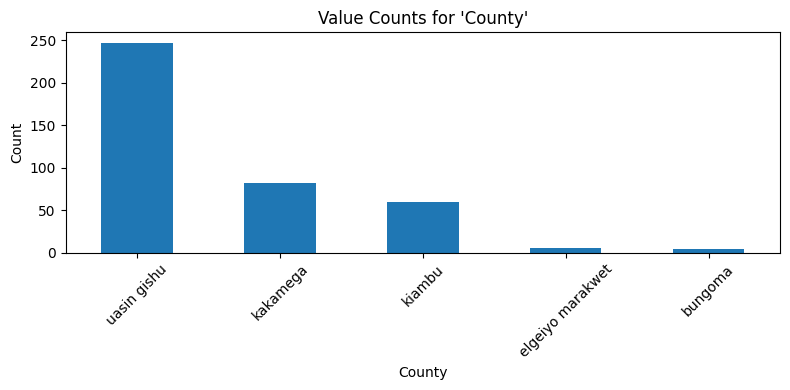

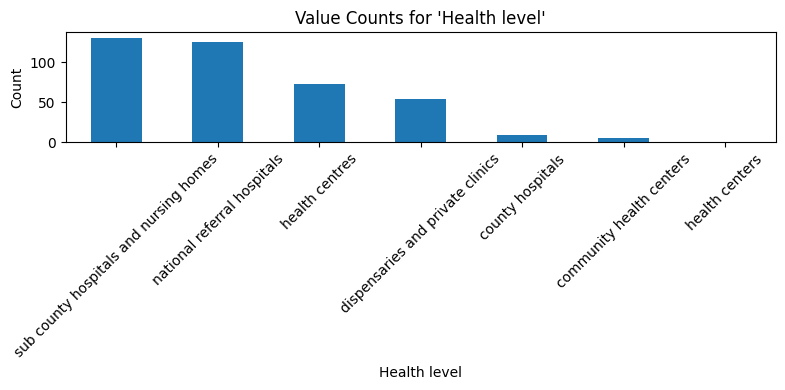

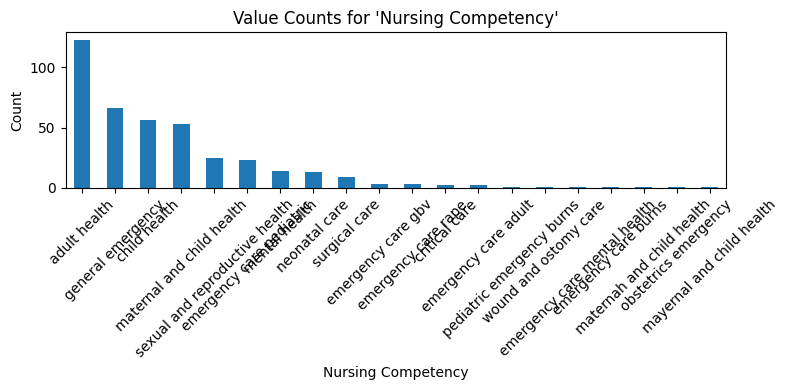

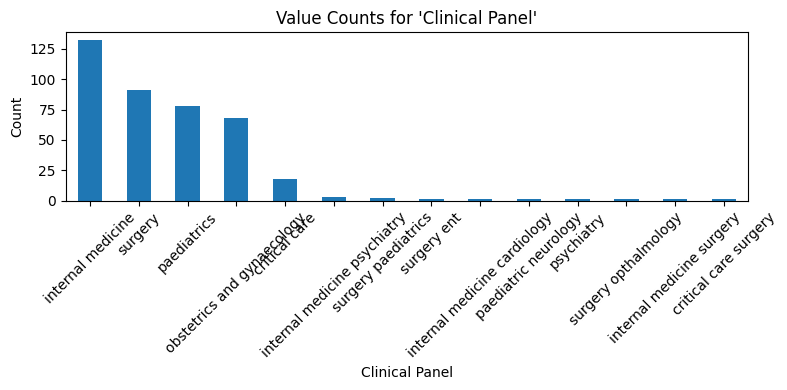

In [ ]:
# 3. Plot count of unique values (for categorical columns)
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() < 50]

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f"Value Counts for '{col}'")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd



# Response fields and corresponding "Source" names
response_fields = {
    'Clinician': 'Clinician',
    'GPT4.0': 'GPT-4.0',
    'LLAMA': 'LLAMA',
    'GEMINI': 'GEMINI'
}

# List to store instruct data
instruct_data = []

for _, row in df.iterrows():
    for field, source_name in response_fields.items():
        if pd.notnull(row[field]):
            entry = {
                "instruction": row['Prompt'],
                "input": "",  # You can add extra context here if needed
                "output": row[field],
                "metadata": {
                    "Master_Index": row['Master_Index'],
                    "County": row['County'],
                    "Health_level": row['Health level'],
                    "Nursing_Competency": row['Nursing Competency'],
                    "Clinical_Panel": row['Clinical Panel'],
                    "Source": source_name,
                    "DDX_SNOMED": row['DDX SNOMED']
                }
            }
            instruct_data.append(entry)

# Save as JSONL
import json

with open("instruct_dataset_with_metadata.jsonl", "w") as f:
    for item in instruct_data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")

print(f"Generated {len(instruct_data)} instruct examples with metadata!")


Generated 1596 instruct examples with metadata!


In [ ]:
def convert_to_chat_template_format(df):
    conversations = []

    for _, row in df.iterrows():
        convo = {
            "messages": [
                {
                    "role": "system",
                    "content": (
                        "You are a clinical decision support assistant. "
                        f"Context:\n"
                        f"- location: {row['County']}, Kenya\n"
                        f"- Facility: {row['Health level']}\n"
                        f"- Nursing Competency: {row['Nursing Competency']}\n"
                        f"- Clinical Panel: {row['Clinical Panel']}"
                    )
                },
                {"role": "user", "content": row["Prompt"]},
                {"role": "assistant", "content": row["Clinician"]},
            ]
        }
        conversations.append(convo)

    return conversations
chat_data = convert_to_chat_template_format(df)
chat_data[0]

{'messages': [{'role': 'system',
   'content': 'You are a clinical decision support assistant. Context:\n- location: uasin gishu, Kenya\n- Facility: sub county hospitals and nursing homes\n- Nursing Competency: pediatric emergency burns\n- Clinical Panel: surgery'},
  {'role': 'user',
   'content': 'i am a nurse with 18 years of experience in general nursing working in a sub county hospitals and nursing homes in uasin gishu county in kenya a 4 year old child presents to the emergency department with second degree burns on the forearm after accidentally touching a hot stove the child was playing in the kitchen when they reached out to touch the stove the burns cover about 5 of the total body surface area the child is alert and crying with redness blisters and swelling on the affected area the burns appear to be superficial to moderate in severity the child is in mild pain and there is no indication of airway or breathing distress no other injuries are noted questions 1 what is the immed

In [ ]:
from transformers import AutoTokenizer
model_name="mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)

# Example: format the 100th conversation using the tokenizer's chat template
formatted_text = [{"text": tokenizer.apply_chat_template(example["messages"], tokenize=False)} for example in chat_data]



/usr/local/lib/python3.11/dist-packages/transformers/models/auto/tokenization_auto.py:898: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


In [ ]:
from datasets import Dataset
hf_dataset = Dataset.from_list(formatted_text)

In [ ]:
print(formatted_text)

# **Finetuning LLM model**

In [ ]:
# Import necessary packages for the fine-tuning process
import os                          # Operating system functionalities
import torch                       # PyTorch library for deep learning
from datasets import load_dataset  # Loading datasets for training
from transformers import (
    AutoModelForCausalLM,          # AutoModel for language modeling tasks
    AutoTokenizer,                # AutoTokenizer for tokenization
    BitsAndBytesConfig,           # Configuration for BitsAndBytes
    HfArgumentParser,             # Argument parser for Hugging Face models
    TrainingArguments,            # Training arguments for model training
    pipeline,                     # Creating pipelines for model inference
    logging,                      # Logging information during training
)
from peft import LoraConfig, PeftModel  # Packages for parameter-efficient fine-tuning (PEFT)
from trl import SFTTrainer         # SFTTrainer for supervised fine-tuning

In [ ]:
# The model that you want to train from the Hugging Face hub
#model_name = "meta-llama/Llama-3.2-1B"



# Fine-tuned model name
new_model = "finetuned_model"

In [ ]:
################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [ ]:
################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results"

# Number of training epochs
num_train_epochs = 1

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

In [ ]:
################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [ ]:
# # Step 1 : Load dataset (you can process it here)
# # The instruction dataset to use
# dataset_name = "mlabonne/guanaco-llama2-1k"
# dataset = load_dataset(dataset_name, split="train")
# dataset

In [ ]:
# # Step 5 :Load LLaMA tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
# def tokenize(example):
#     return tokenizer(
#         example["text"],
#         truncation=True,
#         padding="max_length",
#         max_length=512,  # 👈 set it here
#     )

# tokenized_dataset = formatted_text.map(tokenize, batched=True)


In [ ]:
# tokenized_dataset

In [ ]:
# Step 2 :Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Step 3 :Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

In [ ]:
# Step 4 :Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


OutOfMemoryError: CUDA out of memory. Tried to allocate 1002.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 62.12 MiB is free. Process 98859 has 14.68 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 316.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 2

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

In [ ]:
# Step 6 :Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules= ["q_proj"]#["q_proj"],# "k_proj", "v_proj", "o_proj", "gate_proj", "down_proj", "up_proj"
)

In [ ]:
from peft import get_peft_model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,703,936 || all params: 7,243,436,032 || trainable%: 0.0235


/usr/local/lib/python3.11/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


In [ ]:
# Step 7 :Set training parameters
training_args = TrainingArguments(
    output_dir=output_dir,  # Directory to save model checkpoints & logs
    num_train_epochs=num_train_epochs,  # How many times to iterate over the full dataset
    per_device_train_batch_size=per_device_train_batch_size,  # Batch size per GPU
    gradient_accumulation_steps=gradient_accumulation_steps,  # Simulates larger batch sizes by accumulating gradients
    optim=optim,  # Optimizer (e.g., "adamw_torch")
    save_steps=save_steps,  # How often to save a checkpoint
    logging_steps=logging_steps,  # How often to log training info
    learning_rate=learning_rate,  # Initial learning rate
    weight_decay=weight_decay,  # L2 regularization
    fp16=fp16,  # Use mixed precision (16-bit floating point)
    bf16=bf16,  # Use bfloat16 (on compatible hardware, like A100s)
    max_grad_norm=max_grad_norm,  # Gradient clipping to prevent exploding gradients
    max_steps=max_steps,  # Max training steps (overrides `num_train_epochs` if set)
    warmup_ratio=warmup_ratio,  # Portion of training used for learning rate warm-up
    group_by_length=group_by_length,  # Whether to group sequences of similar lengths for efficient batching
    lr_scheduler_type=lr_scheduler_type,  # Scheduler type (e.g. "cosine", "linear", etc.)
    report_to="tensorboard"  # Reporting backend (could be "wandb", "tensorboard", etc.)
)

In [ ]:
# Step 8 :Set supervised fine-tuning parameters

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset,
    peft_config=peft_config
)

Converting train dataset to ChatML:   0%|          | 0/399 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/399 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/399 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/399 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
# Step 9 :Train model
trainer.train()

# Step 10 :Save trained model
trainer.model.save_pretrained(new_model)

OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 62.12 MiB is free. Process 98859 has 14.68 GiB memory in use. Of the allocated memory 14.24 GiB is allocated by PyTorch, and 316.34 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir results/runs